In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import imageio
from PIL import Image
from torchvision.models import resnet50,ResNet50_Weights
from torchvision import transforms

#Problem 1 - Variants of Backprop for visualizing CNNs

In [2]:
wgts = ResNet50_Weights.IMAGENET1K_V2
preprocess = wgts.transforms()
dnn_model = resnet50(weights = wgts)

img1 = Image.open('i1.jpg')
img2 = Image.open('i2.jpg')
img3 = Image.open('i3.jpg')
img4 = Image.open('i4.jpg')
img5 = Image.open('i5.jpg')
inp_img1 = preprocess(img1).unsqueeze(0)
inp_img2 = preprocess(img2).unsqueeze(0)
inp_img3 = preprocess(img3).unsqueeze(0)
inp_img4 = preprocess(img4).unsqueeze(0)
inp_img5 = preprocess(img5).unsqueeze(0)

In [3]:
def normalise(img):
    invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                    std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                            transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                    std = [ 1., 1., 1. ]),
                            ])
    out = invTrans(img)[0]
    out = out.detach().numpy().transpose(1, 2, 0)
    grads_norm = out
    grads_norm = grads_norm[:,:,0]+ grads_norm[:,:,1]+ grads_norm[:,:,2]
    grads_norm = (grads_norm - np.min(grads_norm))/ (np.max(grads_norm)- np.min(grads_norm))
    return grads_norm

In [4]:
def Plot_Image(img1,img2,title):
  fig,ax = plt.subplots(1,2)
  ax[0].imshow(normalise(img1),cmap='gray')
  ax[1].imshow(normalise(img2),cmap='gray')
  ax[1].set_title(title)

In [5]:
#Vanilla Backprop
def Vanilla_Backprop(img,model):
  model.eval()
  img.requires_grad = True
  dnn_out = model(img)
  target = torch.argmax(dnn_out[0,:])
  model.zero_grad()
  one_hot_out = torch.FloatTensor(1,dnn_out.size()[-1]).zero_()
  one_hot_out[0][target] = 1
  dnn_out.backward(gradient=one_hot_out)
  grad_arr = img.grad
  return grad_arr

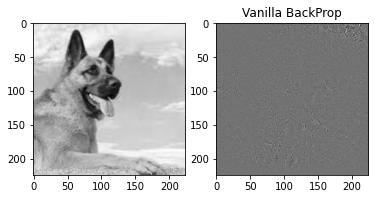

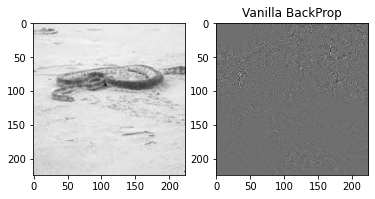

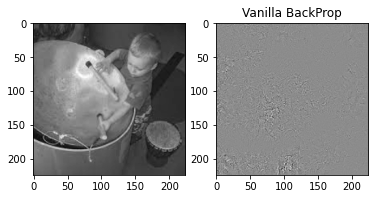

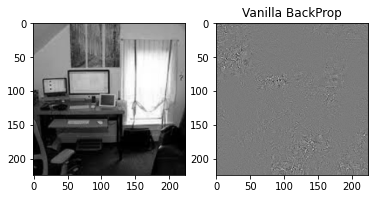

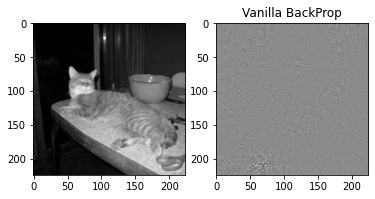

In [6]:
vbp_grad1 = Vanilla_Backprop(inp_img1,dnn_model)
Plot_Image(inp_img1,vbp_grad1,"Vanilla BackProp")

vbp_grad2 = Vanilla_Backprop(inp_img2,dnn_model)
Plot_Image(inp_img2,vbp_grad2,"Vanilla BackProp")

vbp_grad3 = Vanilla_Backprop(inp_img3,dnn_model)
Plot_Image(inp_img3,vbp_grad3,"Vanilla BackProp")

vbp_grad4 = Vanilla_Backprop(inp_img4,dnn_model)
Plot_Image(inp_img4,vbp_grad4,"Vanilla BackProp")

vbp_grad5 = Vanilla_Backprop(inp_img5,dnn_model)
Plot_Image(inp_img5,vbp_grad5,"Vanilla BackProp")

In [7]:
def Guided_BackProp(img,model):
  model.eval()
  def relu_hook_func(module,grad_in,grad_out):
    if isinstance(module,torch.nn.ReLU):
      return (torch.clamp(grad_in[0], min=0.),)
  for i,module in enumerate(model.modules()):
    if isinstance(module,torch.nn.ReLU):
      module.register_backward_hook(relu_hook_func)
  img.requires_grad = True
  dnn_out = model(img)
  target = torch.argmax(dnn_out)
  dnn_out[0,target].backward()
  return img.grad

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


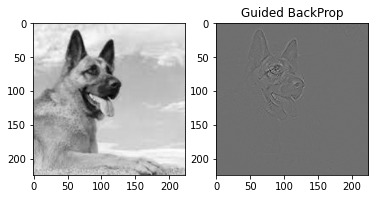

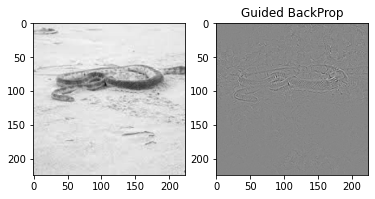

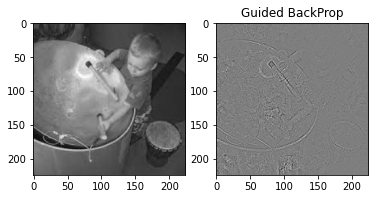

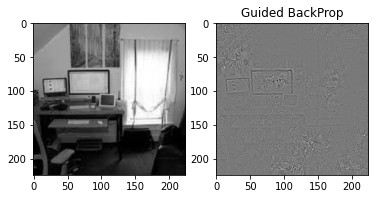

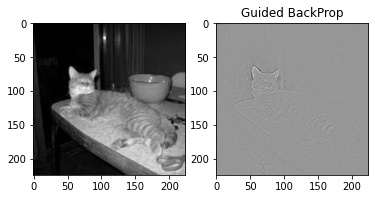

In [8]:
gbp_grad1 = Guided_BackProp(inp_img1,dnn_model)
Plot_Image(inp_img1,gbp_grad1,"Guided BackProp")

gbp_grad2 = Guided_BackProp(inp_img2,dnn_model)
Plot_Image(inp_img2,gbp_grad2,"Guided BackProp")

gbp_grad3 = Guided_BackProp(inp_img3,dnn_model)
Plot_Image(inp_img3,gbp_grad3,"Guided BackProp")

gbp_grad4 = Guided_BackProp(inp_img4,dnn_model)
Plot_Image(inp_img4,gbp_grad4,"Guided BackProp")

gbp_grad5 = Guided_BackProp(inp_img5,dnn_model)
Plot_Image(inp_img5,gbp_grad5,"Guided BackProp")

#Problem 2 - SGD Update rule variations



In [9]:
def f(x,y):
  return 10*(x**2)+y**2

def df_dx(x,y):
  return 20*x

def df_dy(x,y):
  return 2*y

In [10]:
def Vanilla_SGD(x,y,num_epochs,learning_rate):
  path = [(x,y)]
  for i in range(num_epochs):
    x += -1*learning_rate*df_dx(x,y)
    y += -1*learning_rate*df_dy(x,y)
    path.append((x,y))
  return path

In [11]:
def SGD_momentum(x,y,num_epochs,learning_rate,momentum):
  path = [(x,y)]
  vx,vy = 0,0
  for i in range(num_epochs):
    vx = momentum*vx + df_dx(x,y)
    vy = momentum*vy + df_dy(x,y)
    x -= learning_rate*vx
    y -= learning_rate*vy
    path.append((x,y))
  return path

In [12]:
def Nesterov_Momentum(x,y,num_epochs,learning_rate,momentum):
  # x,y =  np.random.uniform(-20, 20), np.random.uniform(-20, 20)
  path = [(x,y)]
  vx,vy = 0,0
  for i in range(num_epochs):
    vx_prev = vx
    vx_prev = vy
    vx = momentum*vx - learning_rate*df_dx(x,y)
    vy = momentum*vy - learning_rate*df_dy(x,y)
    x += -momentum*vx_prev + (1+momentum)*vx
    y += -momentum*vx_prev + (1+momentum)*vy
    path.append((x,y))
  return path

In [13]:
def AdaGrad(x,y,num_epochs,learning_rate,epsilon):
  # x,y =  np.random.uniform(-20, 20), np.random.uniform(-20, 20)
  path = [(x,y)]
  vx,vy = 0,0
  g2x,g2y = 0,0
  for i in range(num_epochs):
    g2x += df_dx(x,y)**2
    g2y += df_dy(x,y)**2
    x -= learning_rate*df_dx(x,y) / (np.sqrt(g2x) + epsilon)
    y -= learning_rate*df_dy(x,y) / (np.sqrt(g2y) + epsilon)
    path.append((x,y))
  return path

In [14]:
def RMSProp(x,y,num_epochs,learning_rate,decay,epsilon):
  # x,y =  np.random.uniform(-20, 20), np.random.uniform(-20, 20)
  path = [(x,y)]
  vx,vy = 0,0
  g2x,g2y = 0,0
  for i in range(num_epochs):
    g2x = decay*g2x + (1-decay)*df_dx(x,y)**2
    g2y = decay*g2y + (1-decay)*df_dy(x,y)**2
    x -= learning_rate*df_dx(x,y) / (np.sqrt(g2x) + epsilon)
    y -= learning_rate*df_dy(x,y) / (np.sqrt(g2y) + epsilon)
    path.append((x,y))
  return path

In [15]:
# Result
x,y = np.random.uniform(-2,2) , np.random.uniform(-2,2)
print("Input:",x,y,"\n")
vbp_path = np.array(Vanilla_SGD(x,y,100,0.025))
print("Vanilla Backprop output:",vbp_path[-1])

sgdm_path = np.array(SGD_momentum(x,y,100,0.0017,0.9))
print("SGD Momentum output:",sgdm_path[-1])

nm_path = np.array(Nesterov_Momentum(x,y,100,0.0017,0.9))
print("Nestrov Momentum output:",nm_path[-1])

ag_path = np.array(AdaGrad(x,y,100,0.45,1e-8))
print("Adagrad output:",ag_path[-1])

rms_path = np.array(RMSProp(x,y,100,0.0345,0.5,1e-8))
print("RMS Prop output:",rms_path[-1])

Input: 0.9098870933534533 0.18228956501438187 

Vanilla Backprop output: [7.17774356e-31 1.07925070e-03]
SGD Momentum output: [ 0.00321948 -0.00040238]
Nestrov Momentum output: [0.00425854 0.00027361]
Adagrad output: [1.20335792e-24 8.42664216e-51]
RMS Prop output: [ 0.01725    -0.01724999]


In [16]:
frames = []
xlist = np.linspace(-2.0, 2.0, 500)
ylist = np.linspace(-2.0, 2.0, 500)
X,Y = np.meshgrid(xlist,ylist)
func_out = 10*X**2 + Y**2

def create_frame(i):
  fig = plt.figure(figsize=(6,6))
  plt.plot(vbp_path[:i,0],vbp_path[:i,1],color='r',label='Vanilla BP')
  plt.plot(sgdm_path[:i,0],sgdm_path[:i,1],color='g',label='SGD Momentum')
  plt.plot(nm_path[:i,0],nm_path[:i,1],color='b',label = 'Nestrov Momentum')
  plt.plot(ag_path[:i,0],ag_path[:i,1],color='y',label='AdaGrad')
  plt.plot(rms_path[:i,0],rms_path[:i,1],color='w',label='RMSProp')
  cp = plt.contourf(X,Y,func_out)
  plt.xlim([-2,2])
  plt.ylim([-2,2])
  plt.legend()
  plt.savefig(f'img_{i}.png',transparent=False,facecolor='white')
  plt.close()

for i in range(101):
  create_frame(i)
  img = imageio.imread(f'img_{i}.png')
  frames.append(img)

imageio.mimsave('sgdupdates.gif',frames,fps=10)